In [1]:
import simtk
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
import numpy as np
from simtk import unit
import copy
sys.path.append('../')
import itertools
from sys import stdout
import tqdm
import matplotlib.pyplot as plt


topology.Topology.loadBondDefinitions('./popc.xml')

pdb = PDBFile('step5_assembly.pdb')
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

water_coords = np.array([pos/nanometer for pos, atom in zip(pdb.positions, pdb.topology.atoms()) if atom.residue.name=='HOH'])
size = water_coords.max(0) - water_coords.min(0)
pdb.topology.setPeriodicBoxVectors([Vec3(x=size[0], y=0, z=0), 
                                   Vec3(x=0, y=size[1], z=0), 
                                   Vec3(x=0, y=0, z=size[2])])


In [2]:
#get the indices of the 'ligand', in this case a sodium ion:
ligand_idx = [i.index for i in pdb.topology.atoms() if i.residue.name == 'NA'][0:1]
ligand_idx


[35529]

In [3]:
def make_system(ff, top,bar=False):
    system = ff.createSystem(top, 
                        nonbondedMethod = PME,
                        nonbondedCutoff = 0.8*nanometer,
                        constraints = HBonds,
                        rigidWater = True, )
    if bar:
        b = MonteCarloMembraneBarostat(1*unit.bar, 
                                       200*unit.bar*unit.nanometer, 
                                       310*unit.kelvin, MonteCarloMembraneBarostat.XYIsotropic, 
                                       MonteCarloMembraneBarostat.ZFree)
        system.addForce(b)
    return system

# Equilibrate (with a barostat - to be removed later)
Basically just setting the box size. Much longer equilibration normally used for lipids but CHARMM-GUI lipid systems are usually pretty close, and there doesn't appear to be any artifacts from not being completely equilibrated. 

In [4]:
system = make_system(forcefield, pdb.topology, bar=True)

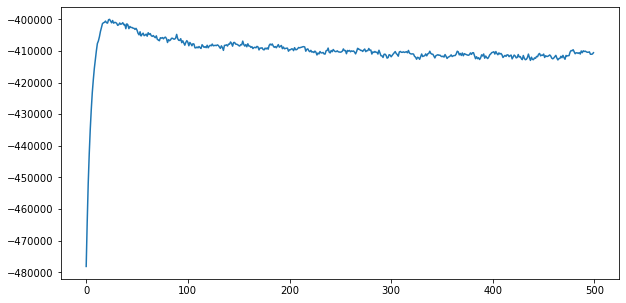

In [5]:
integrator = LangevinIntegrator(310*unit.kelvin, 1/unit.picosecond, 2*unit.femtosecond)
platform = Platform.getPlatformByName('OpenCL')
prop = {'OpenCLPrecision':'single'}

simulation = Simulation(pdb.topology, system, integrator, platform, prop)
simulation.context.setPositions(pdb.positions)

simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature=310*kelvin

simulation.reporters.append(DCDReporter('./short_equil.dcd', 100))


pe = list()
distances = list()
for i in tqdm.tqdm_notebook(range(500)):
    simulation.step(100)
    state = simulation.context.getState(getEnergy=True)
    nrg = state.getPotentialEnergy()
    pe.append(nrg)
    
    
fig, ax = plt.subplots()

fig.set_figwidth(10)
fig.set_figheight(5)

ax.plot([i/unit.kilojoule*unit.mole for i in pe])

In [6]:
#save a state that we can use later:
state = simulation.context.getState(getPositions=True)

# Set up collective variables and UFED:

In [7]:
# first create some forces:
force_x = CustomCentroidBondForce(1, 'x1')
liggrp = force_x.addGroup(ligand_idx)
force_x.addBond([liggrp], [])

force_y = CustomCentroidBondForce(1, 'y1')
liggrp = force_y.addGroup(ligand_idx)
force_y.addBond([liggrp], [])

force_z = CustomCentroidBondForce(1, 'z1')
liggrp = force_z.addGroup(ligand_idx)
force_z.addBond([liggrp], [])

0

In [8]:
import ufedmm
x_cv = ufedmm.CollectiveVariable('x', force_x)
y_cv = ufedmm.CollectiveVariable('y', force_y)
z_cv = ufedmm.CollectiveVariable('z', force_z)

In [9]:
real_cv_positions = list()
for cv in [x_cv, y_cv, z_cv]:
    pos = cv.evaluate(system, state.getPositions())
    real_cv_positions.append(pos)
    print(pos)
    
print(state.getPeriodicBoxVectors())

4.217342376708984
2.894604444503784
6.278036594390869
[Vec3(x=6.333179490980076, y=0.0, z=0.0), Vec3(x=0.0, y=6.320237466884886, z=0.0), Vec3(x=0.0, y=0.0, z=8.522743567599148)] nm


In [10]:
temp = 310*unit.kelvin
gamma = 1/unit.picoseconds
dt = 1*unit.femtoseconds

Ks = 500*unit.kilocalories_per_mole/unit.angstrom**2
Ts = 600*unit.kelvin

height = 0.0*unit.kilojoules_per_mole
deposition_period = 5000


mass = 1000*unit.dalton#*(unit.nanometer/unit.nanometer)**2
sigma = None

In [11]:
pbc = np.array(state.getPeriodicBoxVectors()/nanometer).sum(0)
pbc

array([6.33317949, 6.32023747, 8.52274357])

In [12]:
s_x = ufedmm.DynamicalVariable('s_x', 0.0, pbc[0], mass, 
                                      Ts, x_cv, Ks, sigma=sigma, periodic=True)
s_y = ufedmm.DynamicalVariable('s_y', 0.0, pbc[1], mass, 
                                      Ts, y_cv, Ks, sigma=sigma, periodic=True)
s_z = ufedmm.DynamicalVariable('s_z', 0.0, pbc[2], mass, 
                                      Ts, z_cv, Ks, sigma=sigma, periodic=True)

In [13]:
ufed = ufedmm.UnifiedFreeEnergyDynamics([s_x, s_y, s_z], temp, height, deposition_period)
ufedmm.serialize(ufed, 'ufed_object.yml')

# Create the simulation object:

First, remove the COM force and Barostat force.
Instantiate an integrator, and create the Simulation object.  

In [14]:

for count, force in enumerate(system.getForces()):
    if isinstance(force, CMMotionRemover):
        system.removeForce(count)
for count, force in enumerate(system.getForces()):
    if isinstance(force, MonteCarloMembraneBarostat):
        system.removeForce(count)

integrator = ufedmm.GeodesicLangevinIntegrator(temp, gamma, dt)
#print(integrator)
platform = openmm.Platform.getPlatformByName('OpenCL')
prop = {'OpenCLPrecision':'single'}
simulation = ufed.simulation(pdb.topology, system, integrator, platform, prop)


In [15]:
simulation.context.setPositions(state.getPositions())
simulation.context.setVelocitiesToTemperature(310*unit.kelvin, 1234)
simulation.context.setPeriodicBoxVectors(*state.getPeriodicBoxVectors())

In [16]:
print("Real CV positions:")
print(real_cv_positions)

print("\nExtended particle positions:")
print(simulation.context.getState(getPositions=True).getPositions(extended=True)[1])

Real CV positions:
[4.217342376708984, 2.894604444503784, 6.278036594390869]

Extended particle positions:
[-2.2888011932373047, 3.1376423835754395, -1.8043793439865112]


# Run:

In [17]:
PDBFile.writeFile(pdb.topology, state.getPositions(), 
                             open('./all.pdb', 'w'))
simulation.reporters.append(DCDReporter('./ufed.dcd', 1))
output = ufedmm.Tee(stdout, './output.csv')
reporter = ufedmm.StateDataReporter(output, 1, step=True, multipleTemperatures=True, variables=True, speed=True)

simulation.reporters.append(reporter)

In [18]:
simulation.step(1000)

#"Step","T[atoms] (K)","T[s_x] (K)","T[s_y] (K)","T[s_z] (K)","s_x","x","s_y","y","s_z","z","Speed (ns/day)"
1,313.0515243670191,2.5864533504460003,0.0976147944264223,1.9463664216658993,4.217339992523193,4.217702865600586,2.894603967666626,2.894338607788086,6.278034210205078,6.2781782150268555,0
2,319.36244815831327,3.065152762756158,2.1684637015699395,2.153430887518385,4.217335224151611,4.218043804168701,2.894601345062256,2.8940842151641846,6.278030872344971,6.278320789337158,0.596
3,324.27600423549666,0.9101716675740273,0.6598182531193041,4.538659444795716,4.217331409454346,4.2183709144592285,2.8945977687835693,2.89383864402771,6.278025150299072,6.278453826904297,0.511
4,326.7573926093912,0.2843344677742814,0.422072188020423,5.458459653938174,4.217329978942871,4.218693256378174,2.8945975303649902,2.8936049938201904,6.278018474578857,6.27857780456543,0.489
5,326.6934954489024,2.216910354644391,2.2649824134740046,4.527704866536582,4.217326641082764,4.218997478485107,2.8946003913879395,

44,311.74385849363114,8.320937626078381,100.26926865579294,146.22378298224535,4.217576503753662,4.213067054748535,2.8950273990631104,2.8953304290771484,6.277233123779297,6.274878978729248,0.455
45,311.7301583942558,3.489227718570252,105.50219397922814,134.02406073370554,4.217583656311035,4.213310241699219,2.8950564861297607,2.895308494567871,6.277198791503906,6.27498197555542,0.455
46,312.1281243655535,0.9252327494780701,128.60105721260766,184.04432093425362,4.217586994171143,4.21361780166626,2.895087480545044,2.895284652709961,6.277162075042725,6.275100231170654,0.454
47,312.91718382613533,0.9400920013447506,103.62784207598752,145.82319230812584,4.217588901519775,4.213985919952393,2.895118474960327,2.8952419757843018,6.277124881744385,6.275237083435059,0.454
48,313.8110180993424,0.7009719823319189,93.46978765525466,112.89267723410873,4.217591285705566,4.214415550231934,2.8951470851898193,2.8951797485351562,6.277091979980469,6.275400161743164,0.453
49,314.4834757676344,0.47693310015177

87,311.92622198822363,31.295676353323863,0.11515695392305916,202.13806569586393,4.217446327209473,4.215084075927734,2.895235061645508,2.8966331481933594,6.275130748748779,6.276096820831299,0.451
88,312.13791876817953,59.79268104321636,0.19488011314830442,199.8598672390437,4.217426300048828,4.214482307434082,2.8952364921569824,2.8966333866119385,6.275089740753174,6.2759199142456055,0.451
89,312.60355982717124,74.41862059664608,0.8890066818830759,151.08963314319038,4.217402935028076,4.213924407958984,2.8952386379241943,2.8966362476348877,6.275052070617676,6.275765895843506,0.451
90,313.19188257505647,106.10628525579922,0.21380598373331405,100.17502194573666,4.2173752784729,4.213398456573486,2.8952410221099854,2.8966383934020996,6.275020122528076,6.275626182556152,0.451
91,313.5568893161138,70.34070851218281,5.50646881927321,130.18836516794784,4.217348098754883,4.212924003601074,2.8952383995056152,2.8966586589813232,6.274989128112793,6.275489807128906,0.451
92,313.6441240750077,116.740553

130,313.9221193925968,275.5360111368022,261.9756363128892,0.18259875233725162,4.215476036071777,4.218703269958496,2.8958890438079834,2.899892807006836,6.274272441864014,6.280049800872803,0.451
131,313.06897143023247,350.05569716783293,300.53635208698273,0.0006362421330600173,4.215425968170166,4.21834135055542,2.895937919616699,2.8998219966888428,6.274272441864014,6.279918193817139,0.451
132,312.3410000434639,362.21148497693673,298.6196082082161,2.384843710551917,4.215371608734131,4.217937469482422,2.8959879875183105,2.8997461795806885,6.274275302886963,6.279744625091553,0.451
133,311.9837282638874,277.2011753846123,333.3588255779244,4.075421138159735,4.215320587158203,4.217520236968994,2.8960397243499756,2.8996667861938477,6.274281024932861,6.279538154602051,0.451
134,312.1011946680067,224.78604473862373,351.35053811395653,0.3638455829796976,4.215274810791016,4.217092037200928,2.8960933685302734,2.8995771408081055,6.274285316467285,6.279286861419678,0.451
135,312.47446671728426,242.786

173,311.83453210483196,441.5890007524344,151.61674983856636,93.71624387302472,4.213343620300293,4.2172346115112305,2.897779941558838,2.9006989002227783,6.274979591369629,6.278990745544434,0.451
174,312.3328825554353,406.9079375253428,180.8066224442402,98.00552384569812,4.213284492492676,4.217348575592041,2.897817373275757,2.9005837440490723,6.275008201599121,6.278832912445068,0.451
175,312.74731688591856,423.9526661448108,205.6372347141782,70.98734626193816,4.213226318359375,4.217432498931885,2.897857666015625,2.900428533554077,6.275035858154297,6.278636455535889,0.451
176,313.2908479453034,426.83617128470576,209.63848216772396,76.90503331204219,4.2131667137146,4.2174811363220215,2.8978993892669678,2.9002389907836914,6.275060176849365,6.278390884399414,0.45
177,313.86468282912114,376.7413922783991,228.38078090111296,72.23809246387242,4.213109970092773,4.217480659484863,2.897942304611206,2.9000420570373535,6.27508544921875,6.278087139129639,0.451
178,314.33990852586965,379.4152661808451

216,312.61273778190355,302.37558866781,62.370253229543444,11.99659471014149,4.211390018463135,4.211234092712402,2.8991150856018066,2.8980116844177246,6.275702953338623,6.274848937988281,0.45
217,312.6376962249143,284.54665160404295,75.97111884520002,2.9182768286744736,4.211340427398682,4.2118072509765625,2.8991386890411377,2.8982574939727783,6.275710105895996,6.27498197555542,0.45
218,312.65685784200974,271.5233052166468,69.26737409881736,3.0231517306081614,4.211292743682861,4.212390899658203,2.8991634845733643,2.89849591255188,6.275715351104736,6.275089263916016,0.45
219,312.8583119248409,276.3102717948819,86.14492936914085,2.390026179521811,4.211244583129883,4.212992191314697,2.899188756942749,2.898712635040283,6.275720119476318,6.275174617767334,0.45
220,313.1686344334511,236.5490883529129,113.81426536571689,4.747340400105815,4.211198806762695,4.2136125564575195,2.8992176055908203,2.898902177810669,6.275725364685059,6.27525520324707,0.45
221,313.70741610689294,241.75109579663626,110

259,425.32501536423774,74513.12089023503,211.3981229200235,137757.482255038,3.736321210861206,4.024484157562256,2.900883913040161,2.8845019340515137,5.637334823608398,6.045427322387695,0.45
260,441.12818133398815,85728.99250621581,144.40099757884153,161486.24610896903,3.7371673583984375,3.987403154373169,2.9009206295013428,2.879678964614868,5.638492107391357,5.9988813400268555,0.45
261,443.19851979099906,96392.74996852524,125.45429578036158,184111.03980647042,3.738062620162964,3.9569013118743896,2.900951862335205,2.890043258666992,5.63972806930542,5.9526543617248535,0.45
262,463.1808643718244,106386.72935396517,76.99824996870318,202561.5491206105,3.7390034198760986,3.9254002571105957,2.900979518890381,2.9040989875793457,5.641027927398682,5.904222011566162,0.45
263,472.5584168017041,116659.2289751917,75.13867510526441,220082.93664787218,3.739985466003418,3.8886401653289795,2.9010050296783447,2.918464183807373,5.642380714416504,5.857491493225098,0.45
264,485.0300865462198,122614.65426807

302,486.01147277982125,11870.724855456016,11003.449586874134,34467.374978330765,3.7613818645477295,3.9415059089660645,2.891263008117676,3.0319595336914062,5.661477088928223,5.780602931976318,0.45
303,479.80694167702603,14470.099689809102,8463.047272780634,31589.400619420026,3.761730670928955,3.9532322883605957,2.89099383354187,3.0339949131011963,5.660965919494629,5.826897144317627,0.45
304,472.1378087957782,18058.044714379997,6615.103481831629,27746.184367979866,3.762118339538574,3.9631669521331787,2.890758991241455,3.0346851348876953,5.660486698150635,5.871655464172363,0.45
305,464.7470368996331,22456.091370756858,4963.7306766271195,23412.36511103589,3.7625491619110107,3.9712448120117188,2.890554904937744,3.0340230464935303,5.66004753112793,5.914459705352783,0.45
306,458.1527663716828,27261.38871203311,3502.8544617138095,17277.043508160354,3.7630250453948975,3.9774110317230225,2.890383005142212,3.0320279598236084,5.659664630889893,5.954906940460205,0.45
307,451.58015199573305,33401.98

345,423.12597823116033,126531.29896154183,27187.187001676913,223801.308121648,3.802574872970581,3.6971120834350586,2.8869431018829346,2.7775425910949707,5.702381610870361,5.306880950927734,0.45
346,417.4088980859253,121338.91488557735,29529.233944225805,196694.01305438572,3.8035786151885986,3.6951558589935303,2.886445999145508,2.7885072231292725,5.7036614418029785,5.286196231842041,0.45
347,412.489830432832,113589.64407867257,31746.609673312123,168826.837313884,3.8045551776885986,3.6941850185394287,2.8859312534332275,2.8003621101379395,5.704849720001221,5.2693257331848145,0.45
348,408.7123873887604,107427.56635332508,33703.893225066735,145929.21366050147,3.80550217628479,3.6942226886749268,2.8854007720947266,2.813004493713379,5.705946922302246,5.256433010101318,0.45
349,405.7450149346309,100650.08045821876,35513.5603715532,121434.5762118106,3.8064205646514893,3.6952617168426514,2.884856700897217,2.8263063430786133,5.706953525543213,5.247659206390381,0.45
350,403.5992545302787,95968.891

388,414.71023090376906,128173.6263849348,719.8076873926863,141686.4280116297,3.837104558944702,3.923048496246338,2.8748691082000732,2.8368372917175293,5.717010498046875,6.083550453186035,0.45
389,419.7014457019587,132591.59694192413,610.0376399690548,162029.3947250514,3.8381543159484863,3.916649341583252,2.874939441680908,2.8228275775909424,5.7181715965271,6.058001518249512,0.45
390,424.66011908893415,136131.68558698604,402.8444976558023,182150.33141570791,3.8392200469970703,3.9095234870910645,2.8749985694885254,2.809333086013794,5.719402313232422,6.029414176940918,0.45
391,429.3497147997171,139114.39239632976,207.6733662503728,202564.83607103702,3.840296983718872,3.901754140853882,2.8750412464141846,2.796473741531372,5.720698833465576,5.998054504394531,0.45
392,433.85766674272674,142917.8328220979,61.618129463104836,220013.06808434112,3.84138560295105,3.8934361934661865,2.8750648498535156,2.7843515872955322,5.722053050994873,5.9642205238342285,0.45
393,437.6033332157601,146048.0888598

431,442.2952026026614,46344.39587443762,13078.006016597976,19992.77012724737,3.876345634460449,3.890479803085327,2.8608570098876953,3.004563093185425,5.7480926513671875,5.771238327026367,0.45
432,440.614604640957,47140.0612331405,10606.277222243316,19423.826126538457,3.8769702911376953,3.901651620864868,2.8605587482452393,3.0077004432678223,5.747690200805664,5.812473297119141,0.45
433,437.5815654297922,47831.94457952569,8564.371987061457,18293.661492270156,3.877601146697998,3.9125876426696777,2.8602921962738037,3.0094950199127197,5.74730110168457,5.853058815002441,0.45
434,433.3922013106425,49494.236054178924,6637.11675149219,16216.804305449048,3.8782413005828857,3.9232208728790283,2.8600568771362305,3.0099265575408936,5.7469329833984375,5.8926005363464355,0.45
435,428.51350090359506,50727.96006322611,4785.9875654424495,13601.411931965351,3.8788912296295166,3.933462142944336,2.8598551750183105,3.0089964866638184,5.746596813201904,5.930763244628906,0.45
436,422.9566269173743,51652.25998

474,385.46810065692677,113709.18177160386,19533.490269262016,121307.34272373265,3.9157495498657227,3.8195645809173584,2.8575072288513184,2.747474431991577,5.77979850769043,5.409314155578613,0.45
475,382.4902474596127,110470.62458312351,21921.237976106207,102225.5381393486,3.9167046546936035,3.8167357444763184,2.8570809364318848,2.756859540939331,5.780722618103027,5.3923211097717285,0.45
476,379.8891554603655,105792.50703411367,23975.826542312145,85662.14397388778,3.917642116546631,3.814823627471924,2.8566336631774902,2.7671260833740234,5.781565189361572,5.37887716293335,0.45
477,377.5137930821448,100411.08540237644,26287.034489357422,70138.26297744864,3.9185569286346436,3.813861846923828,2.8561673164367676,2.7781589031219482,5.782326698303223,5.369131088256836,0.45
478,375.858825388363,96550.3536904911,29155.295607464763,54763.19450294545,3.9194507598876953,3.8138527870178223,2.8556792736053467,2.7898545265197754,5.783002853393555,5.363178730010986,0.45
479,375.0595563402548,91643.9588

517,380.79541081704866,115944.70827641057,1221.8353171969347,93167.99523753788,3.948892116546631,4.039026737213135,2.8465731143951416,2.8235976696014404,5.785030364990234,6.143242359161377,0.451
518,385.16373159559885,119823.68133972987,1020.1984568102979,108330.65088834614,3.9498913288116455,4.033919334411621,2.8466670513153076,2.8101634979248047,5.785982608795166,6.122896194458008,0.451
519,389.56926531197115,123707.16414808786,884.8541610000259,124742.13073539198,3.9509060382843018,4.028048515319824,2.846752166748047,2.7970614433288574,5.787001132965088,6.099465847015381,0.451
520,394.184416323651,127067.35615921597,682.1005330560607,141357.78248149218,3.951935291290283,4.0214715003967285,2.846827507019043,2.7844159603118896,5.788085460662842,6.073188304901123,0.451
521,398.51074591909054,130532.54871129335,444.3305793528074,156852.23641681304,3.9529776573181152,4.0142598152160645,2.846889019012451,2.7723453044891357,5.789228439331055,6.044344902038574,0.451
522,402.6132300526148,13

560,410.248503337946,39906.142645761414,11160.816195811467,20771.0969259739,3.987171173095703,3.9696550369262695,2.8349194526672363,2.9616217613220215,5.813388347625732,5.800529956817627,0.45
561,408.59861730707297,39031.69306417678,9160.433637212178,20493.391111634355,3.9877419471740723,3.9742846488952637,2.8346424102783203,2.9665255546569824,5.812972545623779,5.837580680847168,0.45
562,409.86295765988933,38275.58409731041,7301.803890057436,20335.12210200874,3.988307476043701,3.9759392738342285,2.834394931793213,2.970655679702759,5.812562465667725,5.8747782707214355,0.45
563,408.95700136350735,37154.6754904095,5704.274596250674,18637.818414311343,3.988865613937378,3.9769911766052246,2.834177255630493,2.973665714263916,5.812166213989258,5.911561965942383,0.45
564,406.564773096982,37162.241488124746,4069.2619172926297,16850.163838404234,3.9894208908081055,3.9780049324035645,2.8339908123016357,2.9754390716552734,5.811793327331543,5.947432994842529,0.45
565,403.5937421397141,36490.0808279

603,372.4602500563503,52131.23384582766,5189.467246610905,90209.43234010201,4.011570930480957,4.03475284576416,2.835622549057007,2.714010715484619,5.838322639465332,5.505336761474609,0.45
604,368.8275478443386,52986.608719977325,6579.962330154687,76198.64231670204,4.012234210968018,4.032495021820068,2.8353888988494873,2.7185213565826416,5.839118480682373,5.48832893371582,0.45
605,365.71078806951624,53125.41551876579,8093.344786900083,62806.1094977368,4.0129008293151855,4.0299482345581055,2.835129976272583,2.724020004272461,5.839840888977051,5.474562168121338,0.45
606,363.0219810866492,53572.64322492389,9355.02606008794,50438.7889007934,4.01356840133667,4.027156352996826,2.8348491191864014,2.730485439300537,5.840487957000732,5.464146137237549,0.45
607,361.12101866574176,53174.0337452495,10445.178231392632,38864.85332677854,4.014235973358154,4.024162769317627,2.8345513343811035,2.737863302230835,5.8410563468933105,5.4571685791015625,0.45
608,360.30167657733983,53719.95661374425,12107.440

646,365.4539219553476,28340.146982991155,4167.422233939237,69131.79617402074,4.036654949188232,4.053309440612793,2.827723264694214,2.857686758041382,5.842491626739502,6.182304859161377,0.45
647,368.70145192434615,29176.432530296017,4671.384200498723,82086.61937527177,4.037146091461182,4.0571441650390625,2.82791805267334,2.8461661338806152,5.843318939208984,6.165127754211426,0.45
648,372.07429442783933,29106.93072704411,4946.954577625822,96602.20635268111,4.037640571594238,4.060787200927734,2.828119993209839,2.8345112800598145,5.844213485717773,6.145041465759277,0.45
649,375.8656876068125,29717.356224651387,5238.949224264663,109728.04843311332,4.038137435913086,4.064212799072266,2.8283262252807617,2.822807788848877,5.845170021057129,6.122242450714111,0.45
650,379.7555771366679,30054.34798375595,5209.519390736372,123383.34436862475,4.038639068603516,4.067406177520752,2.8285341262817383,2.811152696609497,5.846183776855469,6.096950054168701,0.45
651,383.65292758723115,30967.6077289923,4973

689,396.1741510666922,32217.41024682128,6402.158091468167,17592.07890758799,4.061069965362549,4.015161037445068,2.824406623840332,2.908748149871826,5.868957042694092,5.832976818084717,0.449
690,396.2233023272209,30200.505533249514,5258.53380651042,18008.186695662855,4.0615739822387695,4.01614236831665,2.8241958618164062,2.9161505699157715,5.868568420410156,5.867937088012695,0.449
691,395.7746880938209,28838.312125596844,4252.9903379285,18101.986041813707,4.0620646476745605,4.01754903793335,2.8240067958831787,2.9226882457733154,5.868181228637695,5.902848720550537,0.449
692,394.66700132548567,27110.97935542434,3476.8418253480027,17765.070290659136,4.06254243850708,4.019353866577148,2.8238377571105957,2.9283063411712646,5.867798328399658,5.93740177154541,0.449
693,392.383535021237,25995.835764024723,2530.3797947484018,16129.777198495405,4.063007354736328,4.0215301513671875,2.8236911296844482,2.9329566955566406,5.867430210113525,5.971295356750488,0.449
694,389.7910525828819,25358.138157777

732,366.31587108786755,41659.11464960803,1117.1678059273186,78645.16997639652,4.081051826477051,4.098008155822754,2.8270721435546875,2.725858449935913,5.89011812210083,5.612178325653076,0.449
733,364.09965063266185,41052.46430627478,1761.167945419434,68076.9692346831,4.081640243530273,4.093139171600342,2.8269529342651367,2.732172966003418,5.890870094299316,5.594449043273926,0.449
734,362.04672319921804,41495.57436440254,2308.7585350047684,57350.98484219235,4.082226753234863,4.088178634643555,2.826813220977783,2.7393832206726074,5.8915605545043945,5.579461574554443,0.449
735,359.75706872548477,41275.70970285745,2918.491165294495,46671.58088531926,4.0828142166137695,4.083195686340332,2.8266568183898926,2.747382402420044,5.892184734344482,5.56735897064209,0.449
736,357.6438719451297,41178.27605141004,3459.344928923601,37445.49894514034,4.083400249481201,4.0782365798950195,2.8264856338500977,2.7560856342315674,5.892740726470947,5.558265686035156,0.449
737,355.85071862254705,41400.354206352

775,355.47430846755725,15283.437759268087,9602.793096237689,36572.87808258877,4.100371837615967,4.135173797607422,2.826108455657959,2.8321845531463623,5.891307353973389,6.199382781982422,0.45
776,357.7856649569816,16196.264835505097,9941.561218291437,45676.78233235679,4.100737571716309,4.1395063400268555,2.8263943195343018,2.820861577987671,5.891922950744629,6.186812400817871,0.45
777,360.36883884344115,16452.87490070168,9534.552764068627,54649.68515123238,4.101109504699707,4.143509864807129,2.8266780376434326,2.809565544128418,5.892598628997803,6.171583652496338,0.45
778,363.04932240884443,17471.72423720045,9505.874099813476,65001.07909953951,4.101489543914795,4.147149562835693,2.8269577026367188,2.798415422439575,5.893332004547119,6.153830528259277,0.45
779,365.698598814139,18130.433344992827,9066.568867337433,75396.86873404193,4.101878643035889,4.150417804718018,2.827232599258423,2.787538528442383,5.894123077392578,6.133717060089111,0.45
780,368.28552257923707,18987.655376103066,860

818,381.55983470044555,14007.81703942224,8244.274123110106,7164.960876655779,4.119594097137451,4.082608222961426,2.8327131271362305,2.903691291809082,5.914753437042236,5.867987155914307,0.449
819,382.13441795908244,13471.744864210465,8931.853421889607,7884.988322325681,4.119927883148193,4.086307048797607,2.8329877853393555,2.9009194374084473,5.914498329162598,5.897494316101074,0.449
820,382.5223041502316,12499.234556759448,9720.799524159835,8254.55802949271,4.120253562927246,4.090285778045654,2.83327317237854,2.8975391387939453,5.914237022399902,5.927088260650635,0.449
821,382.2418070077136,12123.997229502667,10850.676300597344,8385.164312138475,4.120570182800293,4.094524383544922,2.8335723876953125,2.893582344055176,5.913975238800049,5.95650577545166,0.449
822,381.3830684371447,11496.05848326282,12242.859977933067,8025.249841909128,4.120881080627441,4.098970890045166,2.833888053894043,2.8890810012817383,5.913718223571777,5.985478401184082,0.449
823,380.36525047273597,11065.51242195613

KeyboardInterrupt: 

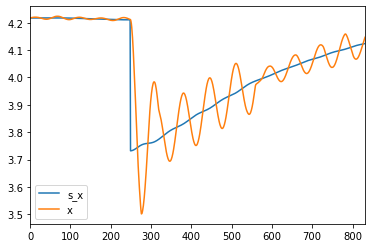

In [19]:
import pandas as pd
df = pd.read_csv('./output.csv')
df[['s_x', 'x']].plot()

In [ ]:
ligand_idx